## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [3]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    y = np.array(y, dtype=np.float64)
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header = 1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header = 1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header = 1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)

normalize_dataset_labels(initial_dataset)

## Criando modelo da rede neural

In [4]:
class Net:
    def build(self, shape = (41,), classes = 10):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        self.built = model
        return model
    
    def compile(self):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                          optimizer = 'adam',
                        metrics = ['accuracy'])

## Criando modelo do servidor

In [12]:
class Server:
    def __init__(self, num_clients, num_labels, input_shape, model = Net()):
        self.global_model = model
        self.num_clients = num_clients
        
        self.global_model.build(classes =num_labels, shape = input_shape)
        self.global_model.compile()
            
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            # Scaling each model weight for each client model with dataset size mean
            for weight in local_weights:
                scaled_weight = weight * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        # agragate local models weights to global model
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)

## Criando modelo do cliente

In [19]:
class Client:
    def __init__(self, client_id = 123, dataset = list(), model = Net(), num_labels = 10):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
        
    def apply_mixed_oversample(self, X, y):
        value_counts = self.local_dataset.iloc[:, -1].value_counts()
        smote_classes, random_classes, k = ({}, {}, sys.maxsize)
        max_count = max(value_counts.values)

        for key, value in value_counts.items():
            if value > 5:
                smote_classes[key] = max_count
                if k > value:
                    k = value - 1
            else:
                random_classes[key] = max_count

        smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
        random_oversample = RandomOverSampler(sampling_strategy = random_classes)
        X, y = smote_oversample.fit_resample(X, y)
        return random_oversample.fit_resample(X, y)
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

        X, y = self.apply_mixed_oversample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
       
        
    def train_model(self):
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = 128,
                                   epochs=1, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        
        prec = precision_score(self.y_test, y_pred, average = 'micro')
        
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test)
        
        self.metrics_history.append((loss, acc, prec))
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 
        
    def plot_result(self, rounds):
        loss_history, acc_history, prec_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy score')
        plt.legend()
        plt.show()
        
        plt.plot(epochs, prec_history, 'r', label='Precision')
        plt.title(f'Precision history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [20]:
def split_dataset_non_iid(clients, num_labels, input_shape):
        unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
        client_index, srcip = (0,0)
        while client_index < num_clients:
            local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip]]
            value_counts = local_dataset['class'].value_counts()
            num_classes = len(value_counts)
            if num_classes > 1:
                print(value_counts)
                clients[client_index].local_dataset = local_dataset
                clients[client_index].num_labels = num_labels
                clients[client_index].input_shape = input_shape
                client_index += 1
            srcip += 1
            
            

num_clients = 20
train_rounds = 10

X = initial_dataset.iloc[:, 5:-1].values
y = initial_dataset.iloc[:, -1].values
num_labels = len(set(y))
input_shape = X.shape[1:]

server = Server(num_clients, num_labels, input_shape)
clients = [Client(client_id = i) for i in range(num_clients)]

split_dataset_non_iid(clients, num_labels, input_shape)

0.0    706880
1.0     89515
6.0       136
2.0        15
4.0        12
3.0         1
Name: class, dtype: int64
0.0    475434
1.0    194196
6.0        78
2.0         1
Name: class, dtype: int64
0.0    450627
1.0        85
Name: class, dtype: int64
0.0    162815
1.0    123354
6.0        52
2.0         2
4.0         2
Name: class, dtype: int64
1.0    146240
0.0    109088
6.0        60
3.0         3
Name: class, dtype: int64
0.0    185126
1.0     14469
3.0        63
4.0         2
6.0         2
Name: class, dtype: int64
0.0    109697
1.0     31222
2.0      1158
3.0         1
Name: class, dtype: int64
0.0    132126
1.0      1611
4.0         1
Name: class, dtype: int64
0.0    124972
1.0       272
Name: class, dtype: int64
0.0    122483
1.0        55
Name: class, dtype: int64
0.0    111212
1.0      9173
Name: class, dtype: int64
1.0    60951
0.0    48522
6.0       45
4.0        5
Name: class, dtype: int64
0.0    108298
1.0        23
Name: class, dtype: int64
0.0    99269
1.0     1685
Name: clas

## Treinando e testando modelos NN locais

In [21]:
for client in clients:
    client.preprocess()

for i in range(train_rounds):
    local_clients_train = list()
    # atualiza os pesos dos modelos locais antes do treinamento
    server.send_global_model_weights(clients)

    for client in clients:
        client.train_model()
        
        # envia pesos do modelo local e tamanho do dataset local de cada cliente pro servidor
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)
    
print(f"[INFO] All local trains are finished!")


[INFO] Local test of client 0
26508/26508 [==============================] - 10s 388us/step - loss: 0.3362 - accuracy: 0.8713
[[ 90285  37966     92   6183   3337   3264]
 [ 25306  89767     72   3839  21081   1399]
 [     0      0 141075      0    238      0]
 [     0      0      0 141209      0      0]
 [    92   3780      0     55 137818      0]
 [  2330      7     70      0     53 138938]]

[INFO] Local test of client 1
11886/11886 [==============================] - 17s 1ms/step - loss: 0.3556 - accuracy: 0.8440
[[56461 30980     7  8051]
 [17597 76118     0  1245]
 [    0     0 94943     0]
 [  769   695     0 93482]]

[INFO] Local test of client 2
5633/5633 [==============================] - 2s 377us/step - loss: 0.2040 - accuracy: 0.9327
[[88817  1593     3]
 [10533 79305     0]
 [    0     0     0]]

[INFO] Local test of client 3
5088/5088 [==============================] - 2s 377us/step - loss: 0.2029 - accuracy: 0.8989
[[26354  6136     3    30    57]
 [10110 22074     3   1

## Plotando resultados dos treinos locais

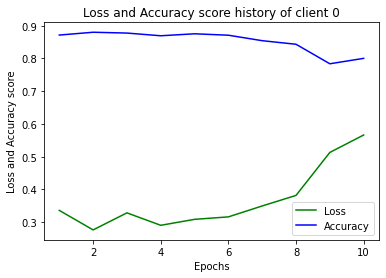

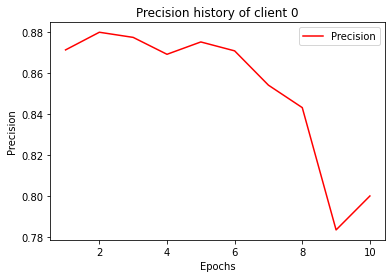

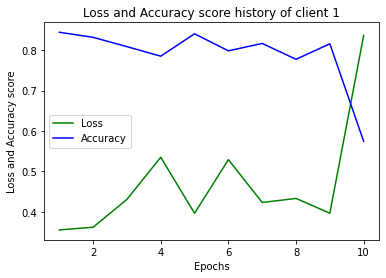

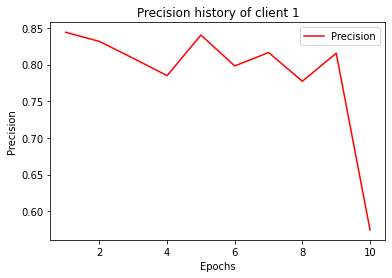

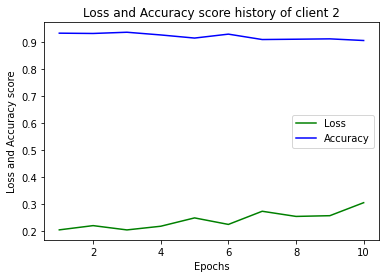

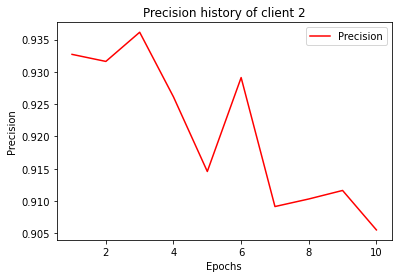

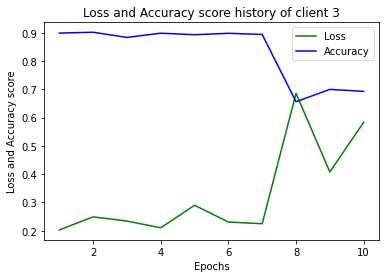

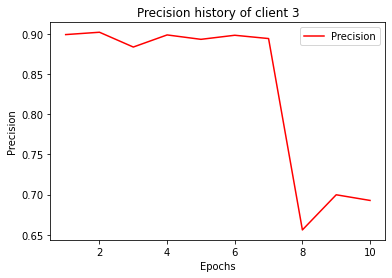

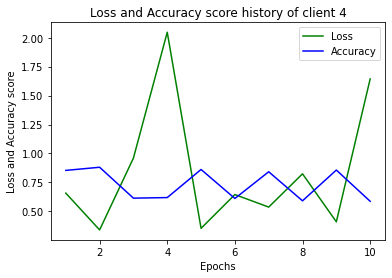

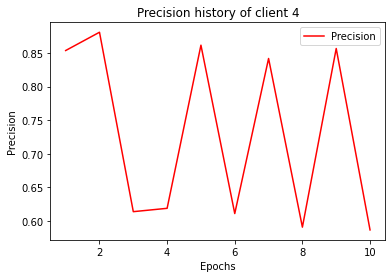

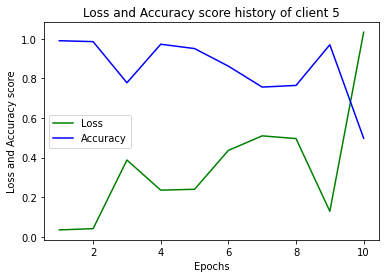

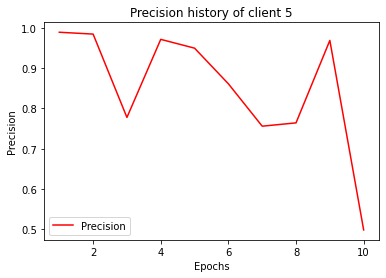

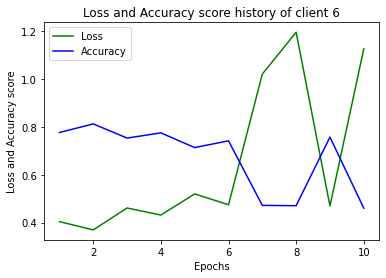

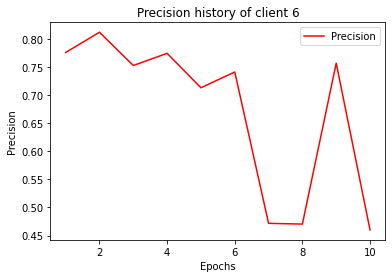

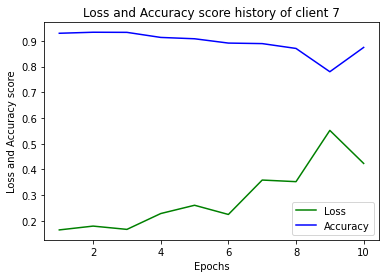

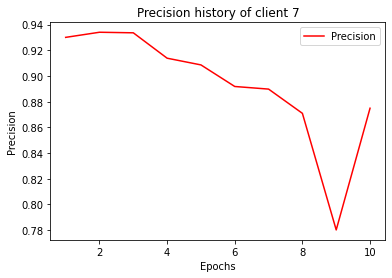

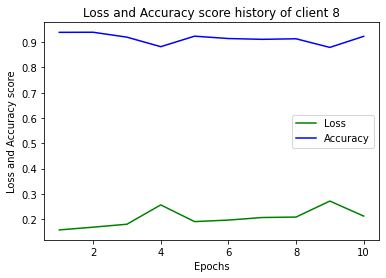

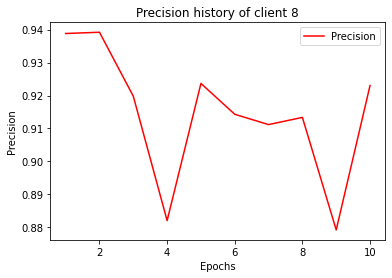

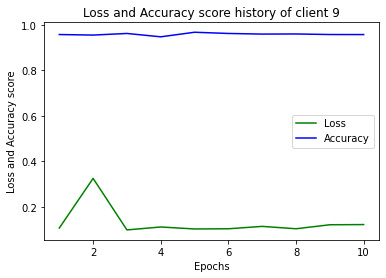

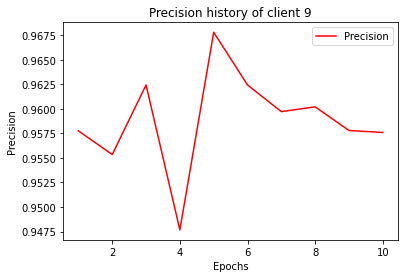

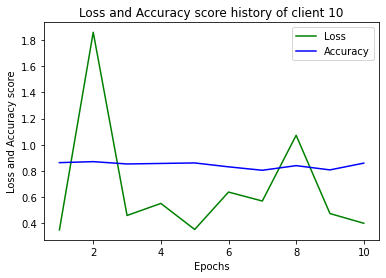

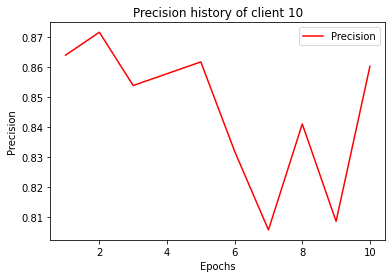

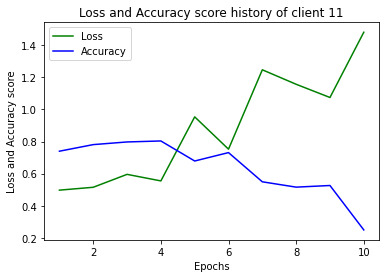

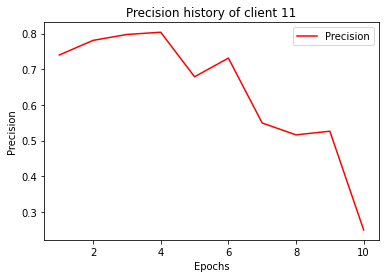

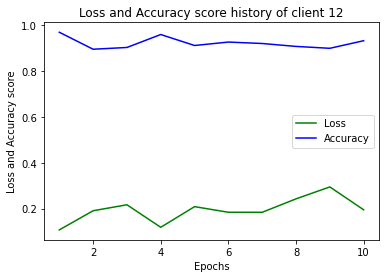

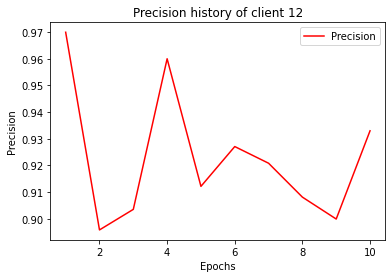

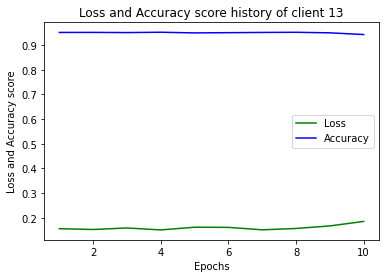

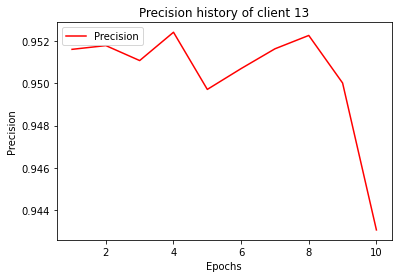

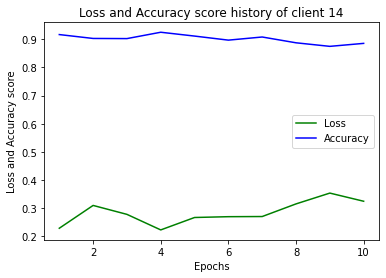

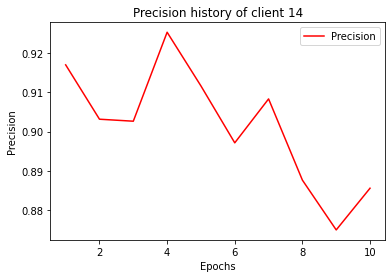

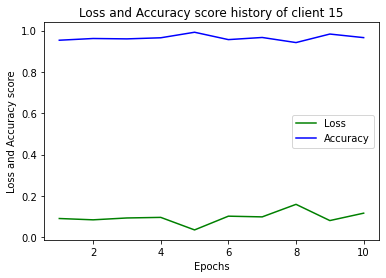

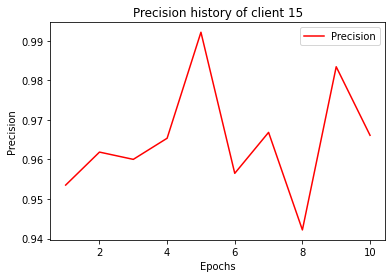

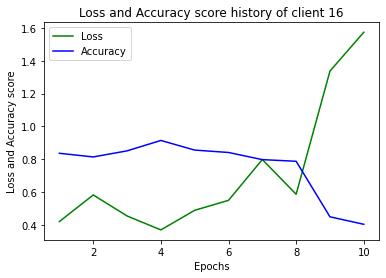

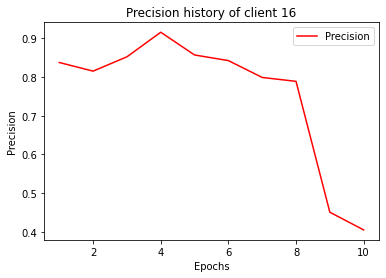

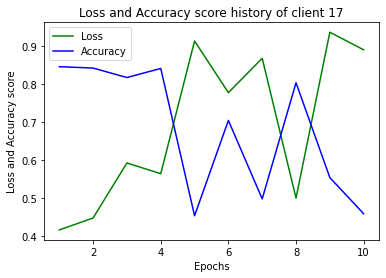

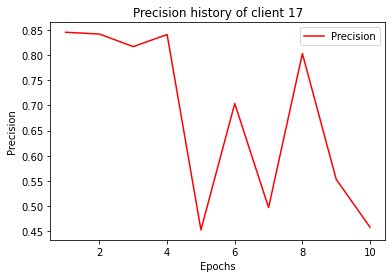

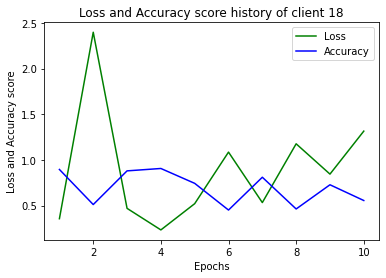

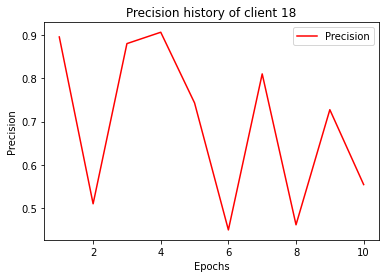

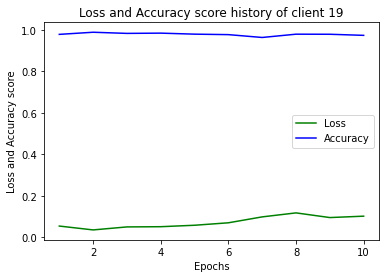

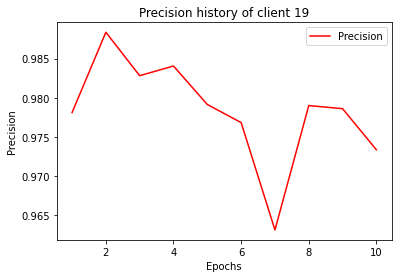

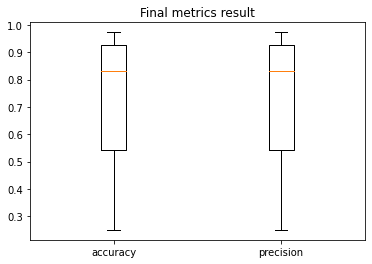

In [22]:
final_metrics = [[],[]]
for client in clients:
    client.plot_result(train_rounds)
    for i in range(1,3):
        final_metrics[i-1].append(client.metrics_history[-1][i])

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1,2], ['accuracy', 'precision'])
plt.show()